C:\Users\edier\miniconda3\Lib\site-packages\scipy\sparse\_data.py:119: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)
C:\Users\edier\miniconda3\Lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 430 disconnected components.
 There are 360 islands with ids: 3, 4, 5, 7, 8, 9, 10, 14, 16, 17, 18, 19, 21, 25, 26, 27, 28, 29, 30, 31, 32, 41, 48, 49, 50, 51, 53, 54, 55, 56, 60, 62, 63, 64, 65, 66, 68, 69, 73, 74, 76, 77, 78, 80, 82, 83, 84, 87, 88, 89, 92, 93, 94, 98, 99, 102, 104, 105, 106, 107, 108, 109, 110, 113, 114, 115, 116, 118, 121, 122, 124, 126, 127, 130, 134, 136, 137, 138, 142, 143, 144, 145, 148, 149, 152, 153, 154, 158, 160, 161, 163, 164, 165, 166, 167, 169, 170, 172, 177, 178, 183, 187, 188, 189, 192, 197, 198, 199, 200, 201, 202, 203, 204, 206, 207, 208, 209, 211, 212, 213, 214, 215, 216, 217, 218, 220, 221, 224, 225, 226, 227, 230, 233, 235, 236, 237, 238, 239, 

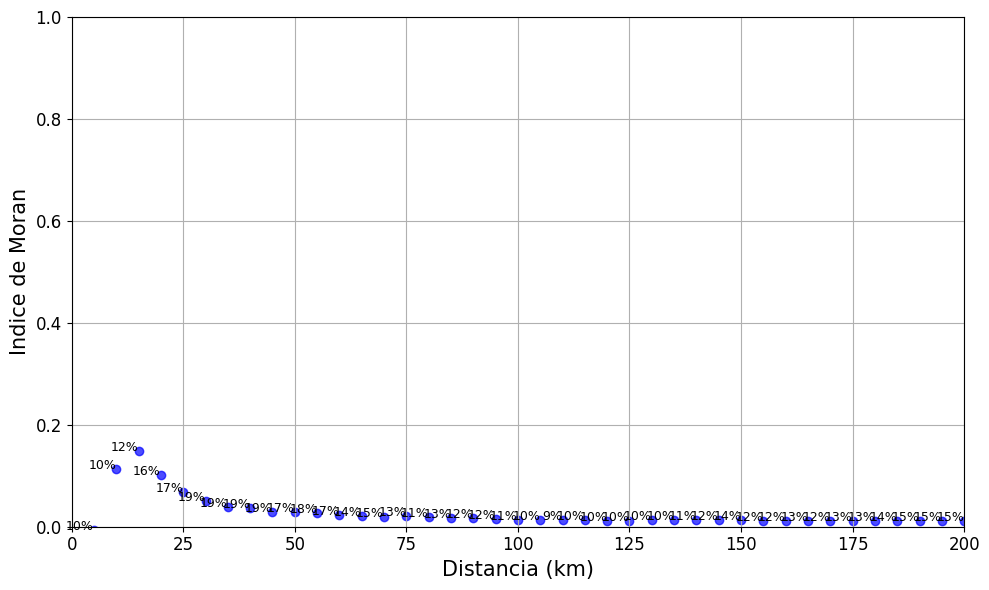

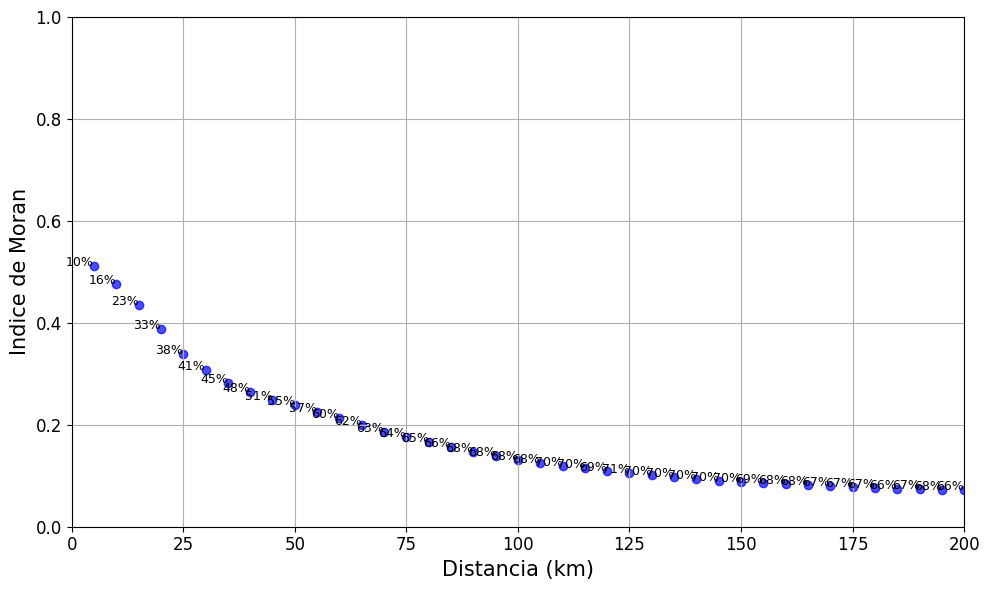

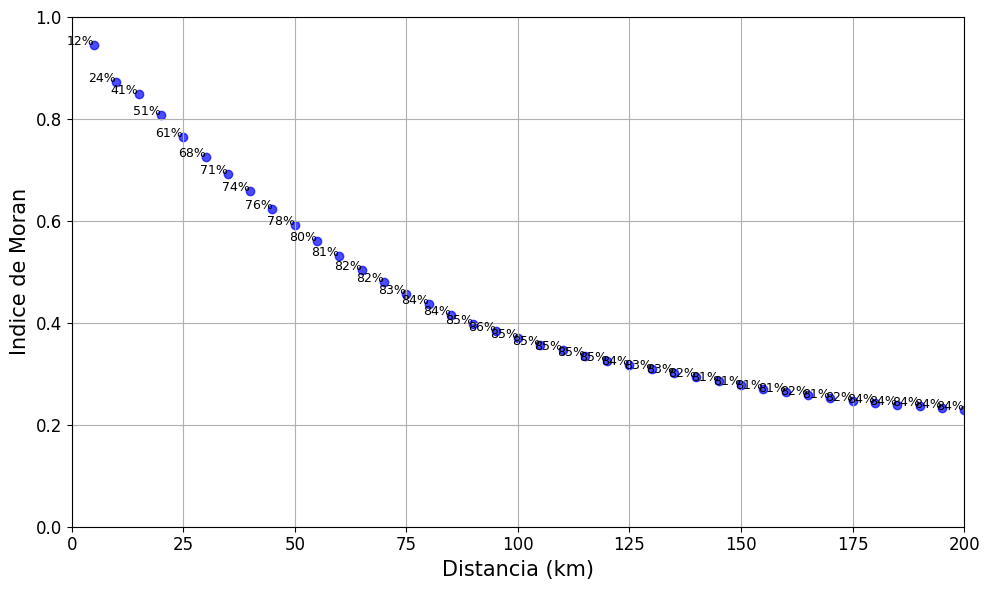

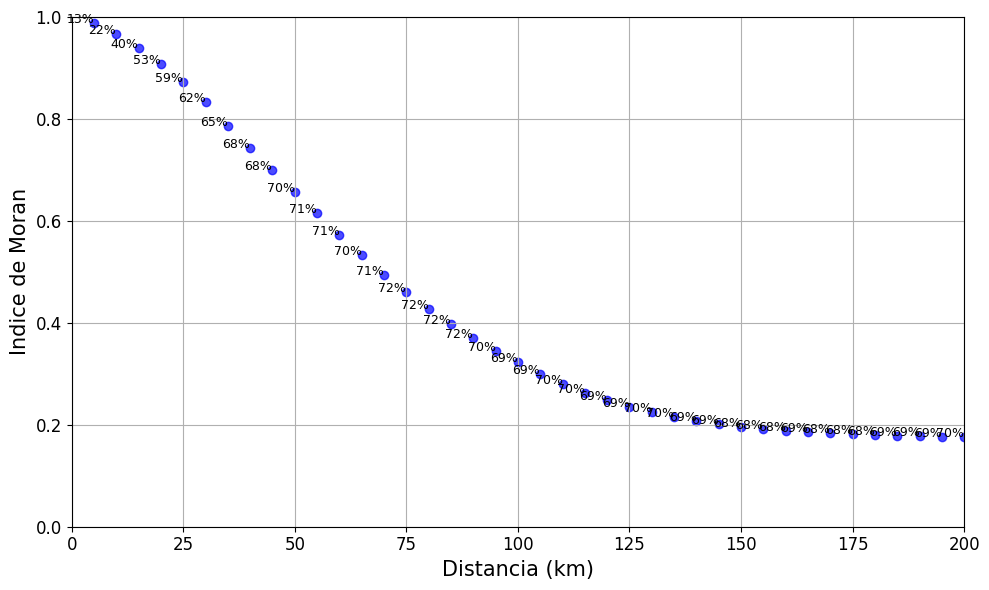

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
from libpysal.weights import DistanceBand
import esda
import numpy as np

# Load the GeoDataFrame
cat = gpd.read_file("G:/My Drive/INVESTIGACION/PAPERS/ELABORACION/Modelo_SAR/DATA/df_catchments_kmeans.gpkg")

# Variables to analyze
variables = ['area', 'hypso_inte', 'slope_mean', 'rainfallAnnual_mean']
distances = range(5000, 200001, 5000)

# Data storage for results
results = {var: {'distances': [], 'mi_values': [], 'significant_percentages': []} for var in variables}

for variable in variables:
    for dx in distances:
        # Create a DistanceBand weights matrix for the specified distance
        w_dist = DistanceBand.from_dataframe(cat, dx, alpha = -1, binary=False)
        
        # Identify islands (disconnected components)
        islands = [k for k, v in w_dist.neighbors.items() if len(v) == 0]

        # Filter out islands from the GeoDataFrame
        cat_filtered = cat.drop(index=islands)

        # Create a new weights matrix without islands
        w_dist_filtered = DistanceBand.from_dataframe(cat_filtered, dx, binary=False)

        # Calculate local Moran's I (using filtered data)
        lisa = esda.Moran_Local(cat_filtered[variable], w_dist_filtered)

        # Calculate the global Moran's I
        mi = esda.Moran(cat_filtered[variable], w_dist_filtered)

        # Calculate percentage of significant observations
        significant = sum(lisa.p_sim < 0.05)
        percentage_significant = (significant / len(lisa.p_sim)) * 100

        # Store results
        results[variable]['distances'].append(dx)
        results[variable]['mi_values'].append(mi.I)
        results[variable]['significant_percentages'].append(percentage_significant)

# Plotting results
for variable in variables:
    plt.figure(figsize=(10, 6))
    distances = results[variable]['distances']
    mi_values = results[variable]['mi_values']
    percentages = results[variable]['significant_percentages']

    # Convert distances to kilometers for the x-axis
    distances_km = [d / 1000 for d in distances]

    plt.scatter(distances_km, mi_values, c='blue', alpha=0.7, label='Moran\'s I')
    for i, perc in enumerate(percentages):
        plt.text(distances_km[i], mi_values[i], f'{int(perc)}%', fontsize=9, ha='right')

    # Set axis labels and ticks
    plt.xlabel('Distancia (km)', fontsize=15)  # Increased font size by 50%
    plt.ylabel('Indice de Moran', fontsize=15)  # Increased font size by 50%
    plt.xticks(fontsize=12)  # Increased font size of x ticks
    plt.yticks(fontsize=12)  # Increased font size of y ticks
    plt.xlim(0, 200)  # Adjusted to show 0 to 200 km
    plt.ylim(0, 1)  # Adjusted y-axis to show 0 to 1
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"G:/My Drive/INVESTIGACION/PAPERS/ELABORACION/Modelo_SAR/FIGURAS/{variable}_moran_vs_distance.png")
    plt.show()
